In [ ]:
# ===============================================================
# 🔧 INSTALL DEPENDENCIES (Face Identity + Emotion + Voice Embeddings + Prosody + Motion)
# ===============================================================
!pip -q install facenet-pytorch deepface transformers torchaudio librosa moviepy tqdm

# ===============================================================
# 📚 IMPORTS
# ===============================================================
import os, cv2, pickle, subprocess
import numpy as np
import pandas as pd
import librosa
import torch
import torchaudio
from tqdm import tqdm
from moviepy.editor import VideoFileClip
from deepface import DeepFace
from facenet_pytorch import MTCNN, InceptionResnetV1
from transformers import Wav2Vec2Processor, Wav2Vec2Model

from google.colab import drive
drive.mount('/content/drive')

# ===============================================================
# 📂 PATHS
# ===============================================================
BASE_DIR = "/content/drive/MyDrive/NNdl/NNDL_Project"
FULL_ANNOT_CSV = os.path.join(BASE_DIR, "subset_annotations.csv")
FULL_VIDEO_DIR = os.path.join(BASE_DIR, "train_subset_3k")

OUT_DIR = "/content/drive/MyDrive/NNdl_Features_Project/features_500"
os.makedirs(OUT_DIR, exist_ok=True)

VIDEO_500_DIR = os.path.join(OUT_DIR, "train_subset_500")
os.makedirs(VIDEO_500_DIR, exist_ok=True)

# Checkpoints
CKPT_X = os.path.join(OUT_DIR, "seq_X_partial.pkl")
CKPT_Y = os.path.join(OUT_DIR, "seq_y_partial.pkl")
CKPT_ID = os.path.join(OUT_DIR, "seq_id_partial.pkl")
CKPT_SET = os.path.join(OUT_DIR, "processed_ids.pkl")

print("Features will be saved in:", OUT_DIR)

# ===============================================================
# ⚙ Device & Models
# ===============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

mtcnn = MTCNN(image_size=160, margin=0, device=device)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

wav_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)
wav_model.eval()

# ===============================================================
# 📄 Load first 500 annotation rows
# ===============================================================
df_full = pd.read_csv(FULL_ANNOT_CSV)
df_500 = df_full.iloc[:500].reset_index(drop=True)

label_cols = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]

annot_500_path = os.path.join(OUT_DIR, "subset_annotations_500.csv")
df_500.to_csv(annot_500_path, index=False)

# ===============================================================
# 🎞 Copy the first 500 videos
# ===============================================================
import shutil
for vid in tqdm(df_500["video"], desc="Copying first 500 videos"):
    src = os.path.join(FULL_VIDEO_DIR, vid)
    dst = os.path.join(VIDEO_500_DIR, vid)
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)

# ===============================================================
# 🔊 AUDIO EXTRACTION
# ===============================================================
def extract_audio_ffmpeg(video_path, target_sr=16000):
    tmp = "/tmp/temp_audio.wav"
    try:
        subprocess.run(
            ["ffmpeg", "-y", "-i", video_path, "-ac", "1", "-ar", str(target_sr), tmp],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        audio, sr = librosa.load(tmp, sr=target_sr)
        return audio.astype(np.float32), sr
    except:
        return None, None

# ===============================================================
# 👤 Identity
# ===============================================================
def extract_identity(frame_bgr):
    try:
        rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        face = mtcnn(rgb)
        if face is None:
            return np.zeros(512, dtype=np.float32)
        with torch.no_grad():
            emb = resnet(face.unsqueeze(0).to(device))
        return emb.cpu().numpy().flatten().astype(np.float32)
    except:
        return np.zeros(512, dtype=np.float32)

# ===============================================================
# 🙂 Emotion
# ===============================================================
def extract_emotion(frame_bgr):
    try:
        res = DeepFace.analyze(frame_bgr, actions=["emotion"], enforce_detection=False, prog_bar=False)
        if isinstance(res, list):
            res = res[0]
        emo = res.get("emotion", {})
        return np.array([
            emo.get("angry",0), emo.get("disgust",0), emo.get("fear",0),
            emo.get("happy",0), emo.get("sad",0), emo.get("surprise",0),
            emo.get("neutral",0)
        ], dtype=np.float32)
    except:
        return np.zeros(7, dtype=np.float32)

# ===============================================================
# 🔊 Wav2Vec2 per-frame segment
# ===============================================================
def extract_w2v_segment(audio, sr, t_sec, win=0.5):
    try:
        center = int(t_sec * sr)
        half = int(sr * win / 2)
        seg = audio[max(0, center-half): min(len(audio), center+half)]
        if len(seg) < 200:
            return np.zeros(768, dtype=np.float32)
        with torch.no_grad():
            inp = wav_processor(seg, sampling_rate=sr, return_tensors="pt")
            out = wav_model(inp.input_values.to(device))
        return out.last_hidden_state.mean(dim=1).cpu().numpy().flatten().astype(np.float32)
    except:
        return np.zeros(768, dtype=np.float32)

# ===============================================================
# 🎚 Prosody
# ===============================================================
def extract_prosody(audio, sr, t_sec, win=0.5):
    try:
        center = int(t_sec * sr)
        half = int(sr * win / 2)
        seg = audio[max(0, center-half): min(len(audio), center+half)]
        if len(seg) < 3:
            return np.zeros(4, dtype=np.float32)

        rms = librosa.feature.rms(y=seg).mean()
        zcr = librosa.feature.zero_crossing_rate(y=seg).mean()
        try:
            f0 = librosa.yin(seg, fmin=50, fmax=400, sr=sr)
            f0 = f0[np.isfinite(f0)]
            pitch = float(np.median(f0)) if len(f0) > 0 else 0.0
        except:
            pitch = 0.0
        energy_var = float(np.var(seg**2))

        return np.array([pitch, rms, zcr, energy_var], dtype=np.float32)
    except:
        return np.zeros(4, dtype=np.float32)

# ===============================================================
# 🎬 Main Per-Video Feature Extractor
# ===============================================================
FRAME_SKIP = 10

def extract_sequence(video_path, audio, sr):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0: fps = 25.0

    feat_list = []
    prev_id = None
    idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if idx % FRAME_SKIP != 0:
            idx += 1
            continue

        t_sec = idx / fps

        id_emb = extract_identity(frame)
        emo = extract_emotion(frame)

        motion = 0.0 if prev_id is None else float(np.linalg.norm(id_emb - prev_id))
        prev_id = id_emb.copy()

        w2v = extract_w2v_segment(audio, sr, t_sec)
        pros = extract_prosody(audio, sr, t_sec)

        feat = np.concatenate([id_emb, emo, np.array([motion],dtype=np.float32), w2v, pros])
        feat_list.append(feat)

        idx += 1

    cap.release()

    if len(feat_list) == 0:
        return None

    return np.vstack(feat_list)   # (T, 1292)

# ===============================================================
# ♻ Resume If Checkpoints Exist
# ===============================================================
if all(os.path.exists(p) for p in [CKPT_X, CKPT_Y, CKPT_ID, CKPT_SET]):
    print("🔁 Resuming checkpoint...")
    seq_X = pickle.load(open(CKPT_X,"rb"))
    seq_y = pickle.load(open(CKPT_Y,"rb"))
    seq_id = pickle.load(open(CKPT_ID,"rb"))
    processed_ids = pickle.load(open(CKPT_SET,"rb"))
else:
    seq_X, seq_y, seq_id = [], [], []
    processed_ids = set()

# ===============================================================
# 🚀 Process First 500 Videos
# ===============================================================
CHECKPOINT_EVERY = 10

for i, row in tqdm(df_500.iterrows(), total=len(df_500)):
    vid = row["video"]
    if vid in processed_ids:
        continue

    vid_path = os.path.join(VIDEO_500_DIR, vid)
    audio, sr = extract_audio_ffmpeg(vid_path, 16000)
    if audio is None:
        processed_ids.add(vid)
        continue

    seq = extract_sequence(vid_path, audio, sr)
    if seq is None:
        processed_ids.add(vid)
        continue

    seq_X.append(seq)
    seq_y.append(row[label_cols].values.astype(np.float32))
    seq_id.append(vid)
    processed_ids.add(vid)

    # Save checkpoint
    if len(seq_id) % CHECKPOINT_EVERY == 0:
        pickle.dump(seq_X, open(CKPT_X,"wb"))
        pickle.dump(seq_y, open(CKPT_Y,"wb"))
        pickle.dump(seq_id, open(CKPT_ID,"wb"))
        pickle.dump(processed_ids, open(CKPT_SET,"wb"))
        print(f"💾 Checkpoint at {len(seq_id)} videos.")

# ===============================================================
# 💾 FINAL SAVE
# ===============================================================
np.save(os.path.join(OUT_DIR,"seq_X_500.npy"), np.array(seq_X, dtype=object), allow_pickle=True)
np.save(os.path.join(OUT_DIR,"seq_y_500.npy"), np.array(seq_y, dtype=np.float32))
np.save(os.path.join(OUT_DIR,"seq_id_500.npy"), np.array(seq_id))

print("\n🎉 DONE — Extracted features for:", len(seq_id))
print("Saved to:", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Features will be saved in: /content/drive/MyDrive/NNdl_Features_Project/features_500
Device: cpu


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 10/500 [05:51<4:50:15, 35.54s/it]

💾 Checkpoint at 10 videos.


  4%|▍         | 20/500 [11:14<4:25:12, 33.15s/it]

💾 Checkpoint at 20 videos.


  6%|▌         | 30/500 [17:26<4:41:00, 35.87s/it]

💾 Checkpoint at 30 videos.


  8%|▊         | 40/500 [23:25<4:17:28, 33.58s/it]

💾 Checkpoint at 40 videos.


 10%|█         | 50/500 [29:01<4:24:59, 35.33s/it]

💾 Checkpoint at 50 videos.


 12%|█▏        | 60/500 [34:10<3:47:29, 31.02s/it]

💾 Checkpoint at 60 videos.


 14%|█▍        | 70/500 [40:27<4:24:36, 36.92s/it]

💾 Checkpoint at 70 videos.


 16%|█▌        | 80/500 [46:27<3:57:24, 33.92s/it]

💾 Checkpoint at 80 videos.


 18%|█▊        | 90/500 [52:13<3:56:03, 34.54s/it]

💾 Checkpoint at 90 videos.


 20%|██        | 100/500 [58:06<4:12:11, 37.83s/it]

💾 Checkpoint at 100 videos.


 22%|██▏       | 110/500 [1:04:44<3:51:51, 35.67s/it]

💾 Checkpoint at 110 videos.


 24%|██▍       | 120/500 [1:10:18<3:29:09, 33.02s/it]

💾 Checkpoint at 120 videos.


 26%|██▌       | 130/500 [1:15:40<2:46:38, 27.02s/it]

💾 Checkpoint at 130 videos.


 28%|██▊       | 140/500 [1:21:50<3:25:35, 34.27s/it]

💾 Checkpoint at 140 videos.


 30%|███       | 150/500 [1:27:22<3:15:35, 33.53s/it]

💾 Checkpoint at 150 videos.


 32%|███▏      | 160/500 [1:33:25<3:16:55, 34.75s/it]

💾 Checkpoint at 160 videos.


 34%|███▍      | 170/500 [1:39:45<3:42:58, 40.54s/it]

💾 Checkpoint at 170 videos.


 36%|███▌      | 180/500 [1:45:15<2:54:23, 32.70s/it]

💾 Checkpoint at 180 videos.


 38%|███▊      | 190/500 [1:50:44<2:57:39, 34.38s/it]

💾 Checkpoint at 190 videos.


 40%|████      | 200/500 [1:56:25<2:53:18, 34.66s/it]

💾 Checkpoint at 200 videos.


 42%|████▏     | 210/500 [2:03:15<3:07:44, 38.84s/it]

💾 Checkpoint at 210 videos.


 44%|████▍     | 220/500 [2:08:42<2:38:27, 33.96s/it]

💾 Checkpoint at 220 videos.


 46%|████▌     | 230/500 [2:14:15<2:28:30, 33.00s/it]

💾 Checkpoint at 230 videos.


 48%|████▊     | 240/500 [2:20:08<2:38:23, 36.55s/it]

💾 Checkpoint at 240 videos.


 50%|█████     | 250/500 [2:25:53<2:21:54, 34.06s/it]

💾 Checkpoint at 250 videos.


 52%|█████▏    | 260/500 [2:32:07<2:37:48, 39.45s/it]

💾 Checkpoint at 260 videos.


 54%|█████▍    | 270/500 [2:39:00<2:38:09, 41.26s/it]

💾 Checkpoint at 270 videos.


 56%|█████▌    | 280/500 [2:44:50<2:08:09, 34.95s/it]

💾 Checkpoint at 280 videos.


 58%|█████▊    | 290/500 [2:50:36<2:02:14, 34.93s/it]

💾 Checkpoint at 290 videos.


 60%|██████    | 300/500 [2:57:24<2:29:06, 44.73s/it]

💾 Checkpoint at 300 videos.


 62%|██████▏   | 310/500 [3:03:07<1:56:15, 36.71s/it]

💾 Checkpoint at 310 videos.


 64%|██████▍   | 320/500 [3:08:49<1:49:37, 36.54s/it]

💾 Checkpoint at 320 videos.


 66%|██████▌   | 330/500 [3:14:29<1:36:54, 34.20s/it]

💾 Checkpoint at 330 videos.


 68%|██████▊   | 340/500 [3:19:58<1:37:50, 36.69s/it]

💾 Checkpoint at 340 videos.


 70%|███████   | 350/500 [3:25:43<1:20:59, 32.39s/it]

💾 Checkpoint at 350 videos.


 72%|███████▏  | 360/500 [3:31:48<1:30:46, 38.90s/it]

💾 Checkpoint at 360 videos.


 74%|███████▍  | 370/500 [3:37:58<1:18:32, 36.25s/it]

💾 Checkpoint at 370 videos.


 76%|███████▌  | 380/500 [3:43:44<1:09:22, 34.69s/it]

💾 Checkpoint at 380 videos.


 78%|███████▊  | 390/500 [3:49:30<1:00:28, 32.99s/it]

💾 Checkpoint at 390 videos.


 80%|████████  | 400/500 [3:55:23<1:00:10, 36.11s/it]

💾 Checkpoint at 400 videos.


 82%|████████▏ | 410/500 [4:01:02<48:01, 32.02s/it]

💾 Checkpoint at 410 videos.


 84%|████████▍ | 420/500 [4:06:53<43:55, 32.94s/it]

💾 Checkpoint at 420 videos.


 86%|████████▌ | 430/500 [4:12:24<38:58, 33.41s/it]

💾 Checkpoint at 430 videos.


 88%|████████▊ | 440/500 [4:18:21<34:19, 34.32s/it]

💾 Checkpoint at 440 videos.


 90%|█████████ | 450/500 [4:23:28<24:06, 28.94s/it]

💾 Checkpoint at 450 videos.


 92%|█████████▏| 460/500 [4:29:14<21:45, 32.64s/it]

💾 Checkpoint at 460 videos.


 94%|█████████▍| 470/500 [4:34:58<17:40, 35.35s/it]

💾 Checkpoint at 470 videos.


 96%|█████████▌| 480/500 [4:40:35<12:20, 37.01s/it]

💾 Checkpoint at 480 videos.


 98%|█████████▊| 490/500 [4:46:38<05:38, 33.88s/it]

💾 Checkpoint at 490 videos.


100%|██████████| 500/500 [4:52:27<00:00, 35.09s/it]

💾 Checkpoint at 500 videos.



🎉 DONE — Extracted features for: 500
Saved to: /content/drive/MyDrive/NNdl_Features_Project/features_500


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (46, 1292)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0459 | Val 0.0254 | MSE 0.0255 | MAE 0.1298 | R² -0.1153 | Acc±0.1 45.07%
Epoch 2 | Train 0.0314 | Val 0.0233 | MSE 0.0243 | MAE 0.1249 | R² -0.0517 | Acc±0.1 47.20%
Epoch 3 | Train 0.0278 | Val 0.0234 | MSE 0.0239 | MAE 0.1287 | R² -0.0430 | Acc±0.1 42.93%
Epoch 4 | Train 0.0264 | Val 0.0259 | MSE 0.0260 | MAE 0.1333 | R² -0.1292 | Acc±0.1 42.93%
Epoch 5 | Train 0.0291 | Val 0.0221 | MSE 0.0229 | MAE 0.1246 | R² 0.0008 | Acc±0.1 45.60%
Epoch 6 | Train 0.0278 | Val 0.0217 | MSE 0.0224 | MAE 0.1224 | R² 0.0274 | Acc±0.1 47.20%
Epoch 7 | Train 0.0280 | Val 0.0249 | MSE 0.0253 | MAE 0.1323 | R² -0.1010 | Acc±0.1 40.53%
Epoch 8 |

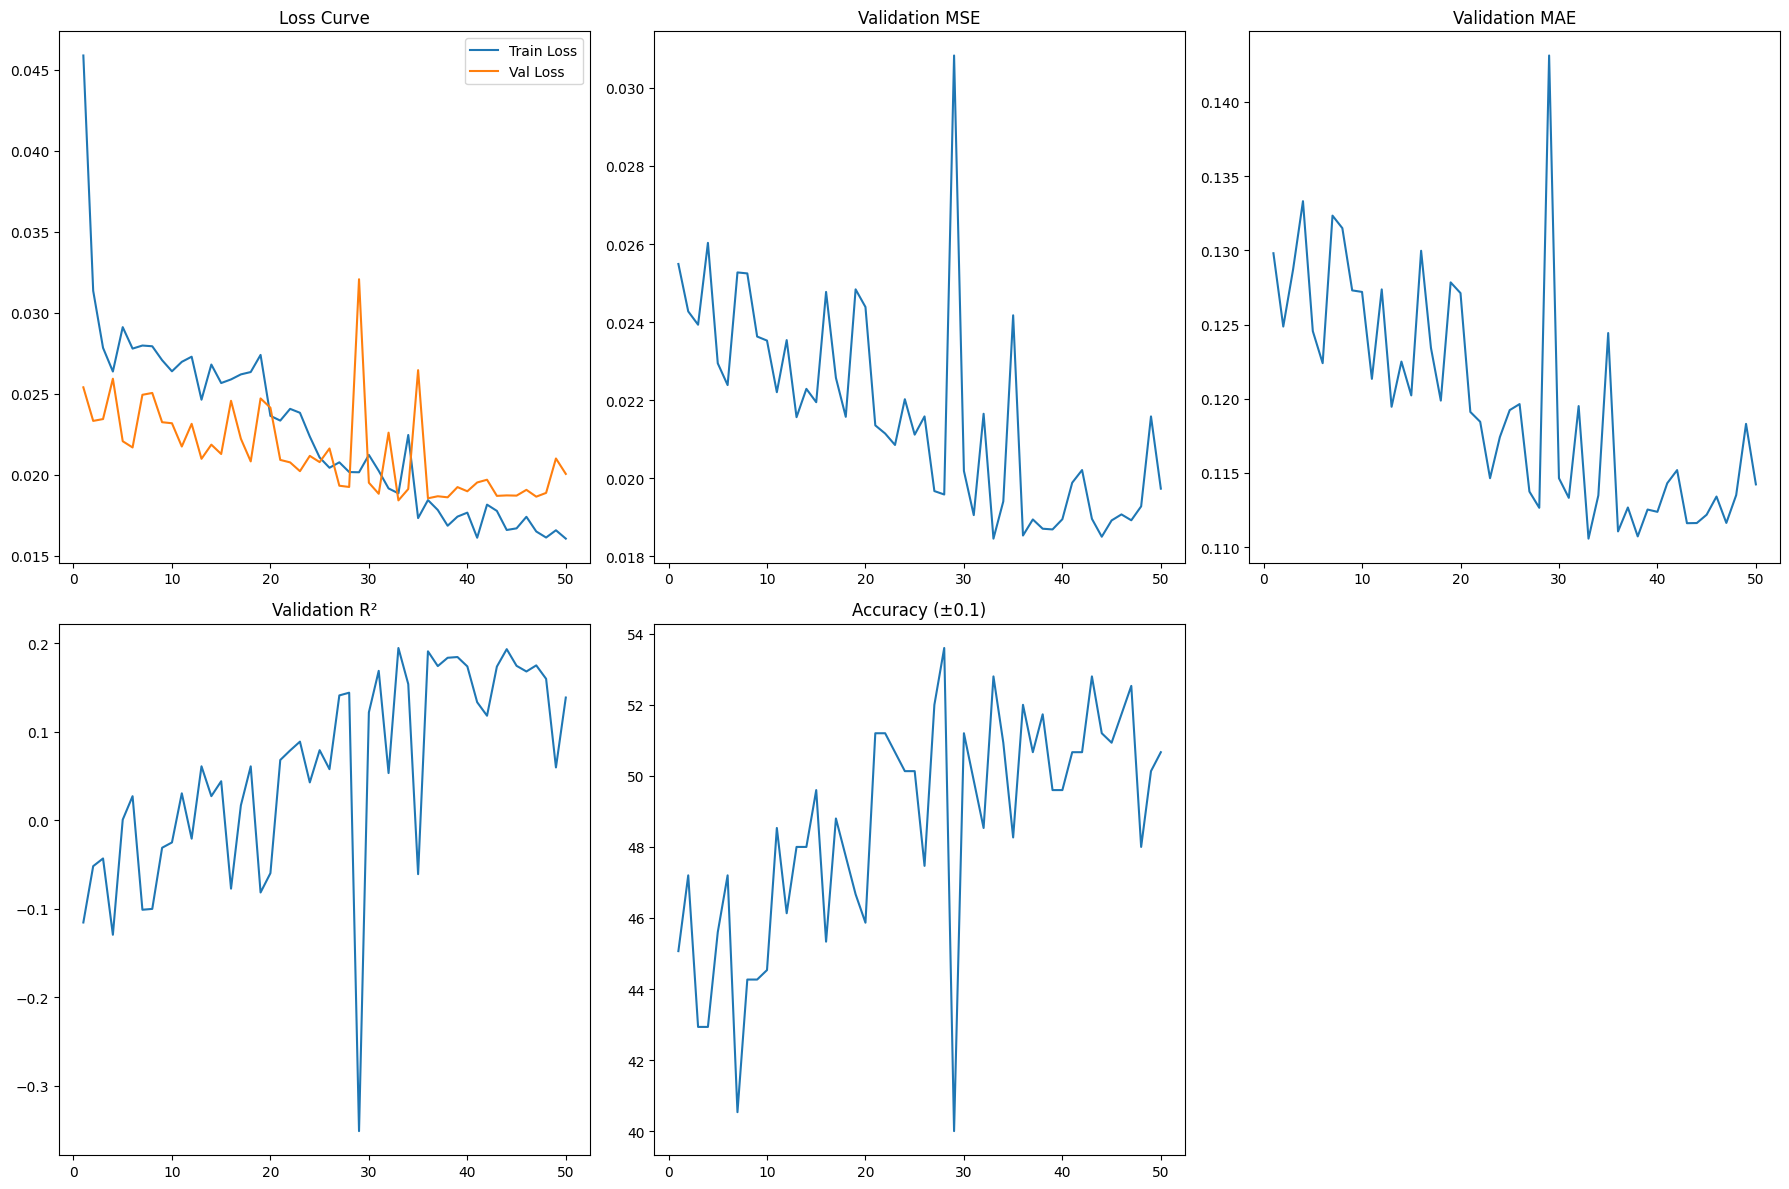


================= FINAL TEST RESULTS =================
MSE: 0.0197
MAE: 0.1116
R²:  -0.1776
Accuracy ±0.1: 52.27%


In [ ]:
# ============================================================
# 📦 Install & Imports (1D Conco + Transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Features_Project/features_500/"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial.pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial.pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial.pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)

# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Conv1D + Transformer Model
# ============================================================
class OceanConvTransformer(nn.Module):
    def __init__(self, input_dim=1291, d_model=256, nhead=8,
                 num_layers=3, dim_feedforward=512, dropout=0.2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, _ = x.shape

        x = self.input_proj(x)

        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)

        cls_tok = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_tok, x], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        x = self.encoder(x, src_key_padding_mask=key_mask)
        cls_out = x[:, 0]
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Store Metrics
# ============================================================
train_loss_history = []
val_loss_history   = []
val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []


# ============================================================
# 🏋️ Training Loop  (NO EARLY STOPPING)
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanConvTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

EPOCHS = 50

for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)

        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")


# ============================================================
# 📈 PLOT GRAPHS
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy (±0.1)")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 FINAL TEST EVALUATION
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (46, 1292)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0593 | Val 0.0192 | MSE 0.0190 | MAE 0.1103 | R² -0.0047 | Acc±0.1 52.00%
Epoch 2 | Train 0.0326 | Val 0.0211 | MSE 0.0200 | MAE 0.1100 | R² -0.0549 | Acc±0.1 56.80%
Epoch 3 | Train 0.0293 | Val 0.0175 | MSE 0.0172 | MAE 0.1036 | R² 0.0885 | Acc±0.1 56.53%
Epoch 4 | Train 0.0249 | Val 0.0191 | MSE 0.0191 | MAE 0.1118 | R² -0.0131 | Acc±0.1 49.07%
Epoch 5 | Train 0.0253 | Val 0.0166 | MSE 0.0164 | MAE 0.1026 | R² 0.1241 | Acc±0.1 56.80%
Epoch 6 | Train 0.0246 | Val 0.0189 | MSE 0.0183 | MAE 0.1041 | R² 0.0344 | Acc±0.1 56.27%
Epoch 7 | Train 0.0208 | Val 0.0192 | MSE 0.0189 | MAE 0.1074 | R² -0.0038 | Acc±0.1 56.80%
Epoch 8 | 

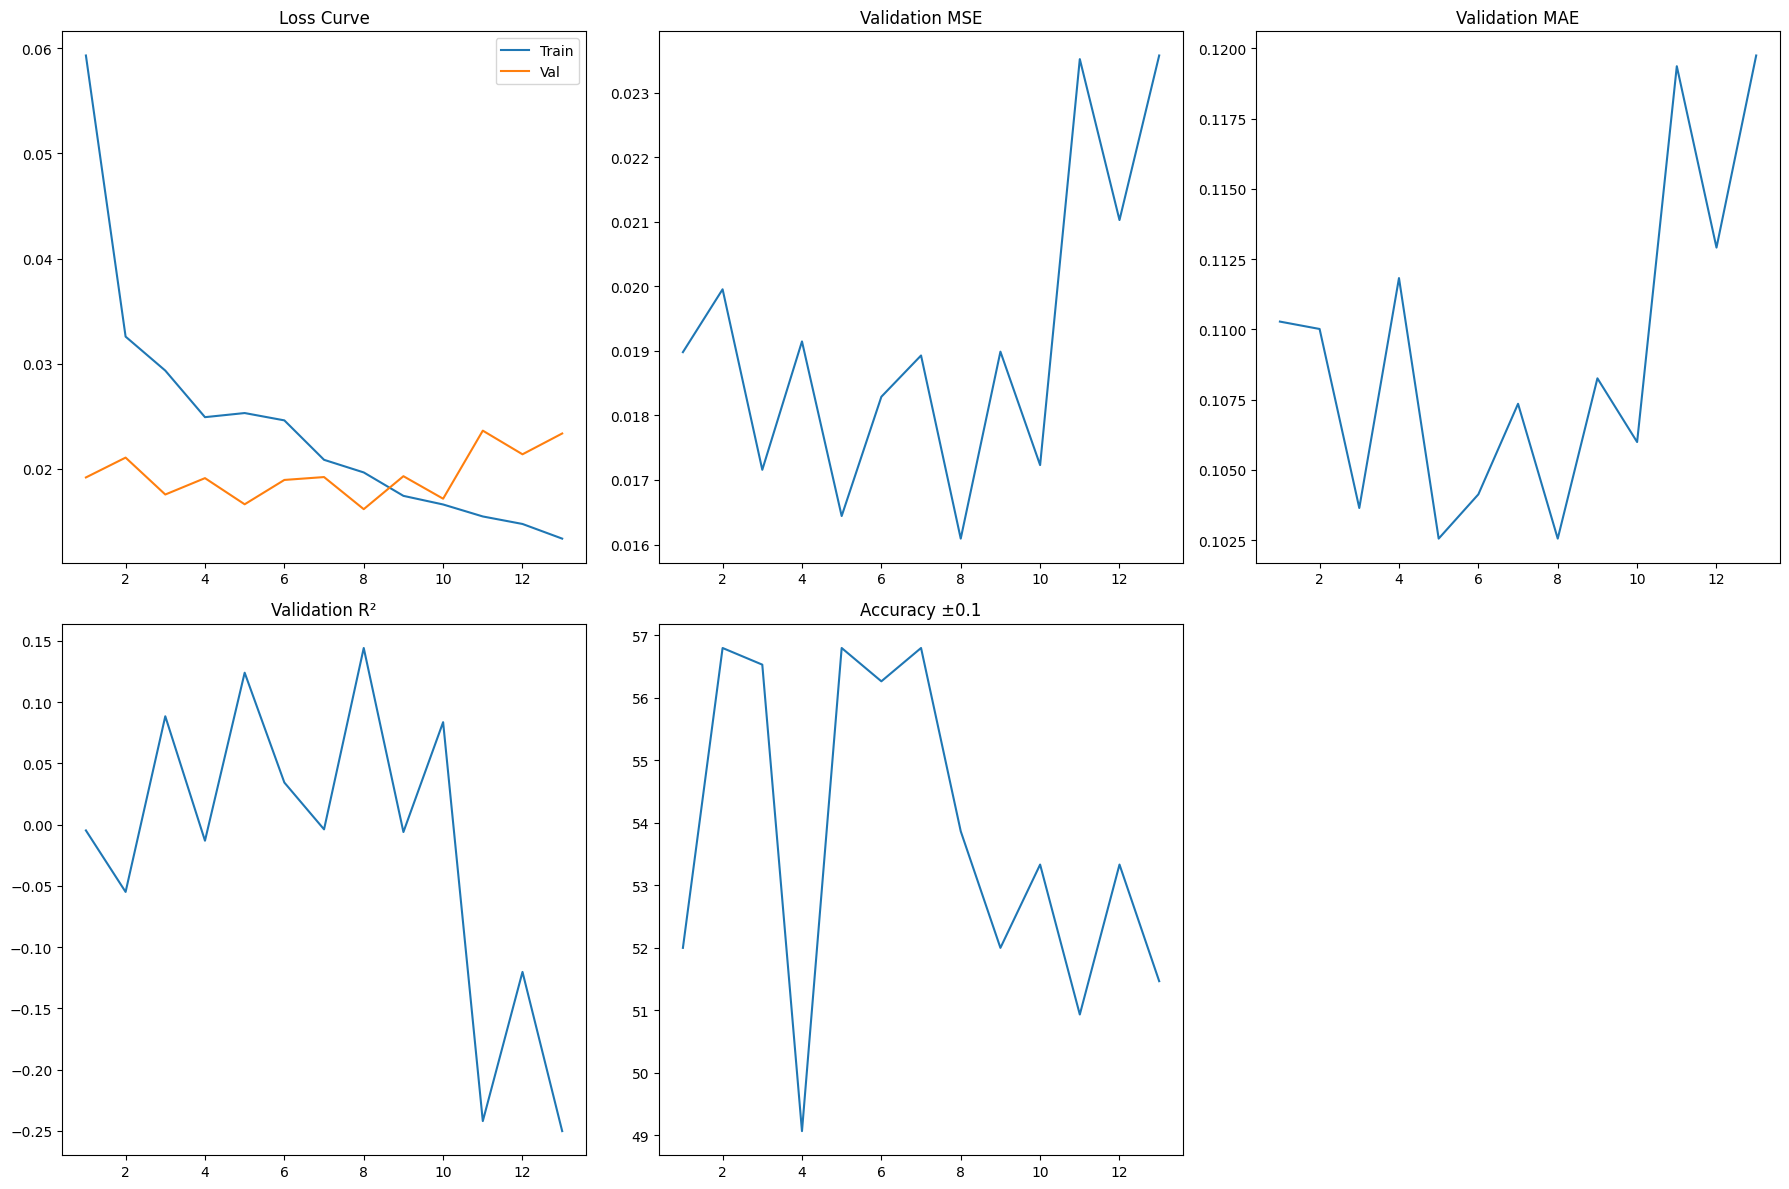


================= FINAL TEST RESULTS =================
MSE: 0.0197
MAE: 0.1103
R²:  0.1255
Accuracy ±0.1: 53.33%


In [ ]:
# ============================================================
# 📦 Install & Imports  (HCAFT)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Features_Project/features_500/"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial.pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial.pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial.pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)  # (T, 1291)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 HCAFT: Encoders + Cross-Attention + BiGRU + Transformer
# ============================================================
class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention block:
    Q attends to K,V using MultiheadAttention.
    """
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
        )
        self.ff_ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        # q,k,v: (B, T, dim)
        attn_out, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln(q + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ff_ln(x + self.dropout(ff_out))
        return x


class OceanHCAFT(nn.Module):
    def __init__(
        self,
        input_dim=1291,
        clip_dim=512,
        fer_dim=7,
        wav_dim=768,
        prosody_dim=4,
        clip_enc_dim=128,
        fer_enc_dim=32,
        wav_enc_dim=128,
        prosody_enc_dim=16,
        d_model=256,
        nhead_xattn=4,
        nhead_transformer=8,
        num_layers_transformer=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # -------------------------
        # 🔹 1. Modality Encoders (frame-level)
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(fer_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(prosody_enc_dim),
        )

        # -------------------------
        # 🔹 2. Cross-Attention Fusion (frame-level)
        # CLIP ↔ Audio (Wav2Vec2)
        # -------------------------
        # Q = CLIP, K,V = Audio
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead=nhead_xattn, dropout=dropout)
        # Q = Audio, K,V = CLIP
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead=nhead_xattn, dropout=dropout)

        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # -------------------------
        # 🔹 3. BiGRU (segment / local temporal modeling)
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 4. Video-level Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_transformer,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)

        # -------------------------
        # 🔹 5. OCEAN Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),   # O, C, E, A, N
        )

    def forward(self, x, mask):
        """
        x:    (B, T, 1291)
        mask: (B, T) with 1 for valid, 0 for padded
        """
        B, T, D = x.shape

        # -------------------------
        # Split modalities
        # -------------------------
        x_clip = x[:, :, 0:self.clip_dim]  # (B, T, 512)
        x_fer  = x[:, :, self.clip_dim:self.clip_dim + self.fer_dim]  # (B, T, 7)
        x_wav  = x[:, :, self.clip_dim + self.fer_dim:self.clip_dim + self.fer_dim + self.wav_dim]  # (B, T, 768)
        x_pros = x[:, :, -self.prosody_dim:]  # (B, T, 4)

        # -------------------------
        # Frame-level encoding
        # -------------------------
        e_clip = self.clip_encoder(x_clip)    # (B, T, clip_enc_dim)
        e_fer  = self.fer_encoder(x_fer)      # (B, T, fer_enc_dim)
        e_wav  = self.wav_encoder(x_wav)      # (B, T, wav_enc_dim)
        e_pros = self.prosody_encoder(x_pros) # (B, T, prosody_enc_dim)

        # -------------------------
        # Cross-Attention: CLIP ↔ Audio
        # -------------------------
        # Prepare key padding masks: True where PAD
        key_padding = (mask == 0)  # (B, T)

        # CLIP attends to Audio
        clip_from_audio = self.cross_clip_from_audio(
            q=e_clip,
            k=e_wav,
            v=e_wav,
            key_padding_mask=key_padding
        )  # (B, T, clip_enc_dim)

        # Audio attends to CLIP
        audio_from_clip = self.cross_audio_from_clip(
            q=e_wav,
            k=e_clip,
            v=e_clip,
            key_padding_mask=key_padding
        )  # (B, T, wav_enc_dim)

        # Fuse all enriched features
        fused = torch.cat(
            [clip_from_audio, audio_from_clip, e_fer, e_pros],
            dim=-1
        )  # (B, T, fused_dim)

        fused = self.fuse_proj(fused)  # (B, T, d_model)

        # -------------------------
        # BiGRU for local temporal modeling
        # -------------------------
        gru_out, _ = self.bigru(fused)  # (B, T, d_model) since bidirectional
        gru_out = self.gru_ln(gru_out)

        # -------------------------
        # Video-level Transformer with [CLS]
        # -------------------------
        cls_tok = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        seq = torch.cat([cls_tok, gru_out], dim=1)  # (B, T+1, d_model)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)  # (B, T+1)
        key_padding_mask = (full_mask == 0)  # True where pad

        enc = self.encoder(seq, src_key_padding_mask=key_padding_mask)  # (B, T+1, d_model)
        cls_out = enc[:, 0]  # (B, d_model)

        # -------------------------
        # OCEAN prediction
        # -------------------------
        out = self.head(cls_out)  # (B, 5)
        return out


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanHCAFT(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train")
plt.plot(epochs, val_loss_history, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (46, 1292)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0479 | Val 0.0249 | MSE 0.0245 | MAE 0.1240 | R² -0.1276 | Acc±0.1 48.00%
Epoch 2 | Train 0.0296 | Val 0.0260 | MSE 0.0254 | MAE 0.1268 | R² -0.1498 | Acc±0.1 48.53%
Epoch 3 | Train 0.0267 | Val 0.0235 | MSE 0.0230 | MAE 0.1217 | R² -0.0717 | Acc±0.1 47.73%
Epoch 4 | Train 0.0249 | Val 0.0243 | MSE 0.0235 | MAE 0.1244 | R² -0.0735 | Acc±0.1 48.80%
Epoch 5 | Train 0.0215 | Val 0.0191 | MSE 0.0185 | MAE 0.1098 | R² 0.1488 | Acc±0.1 50.93%
Epoch 6 | Train 0.0222 | Val 0.0219 | MSE 0.0214 | MAE 0.1200 | R² 0.0200 | Acc±0.1 48.00%
Epoch 7 | Train 0.0191 | Val 0.0193 | MSE 0.0191 | MAE 0.1133 | R² 0.1199 | Acc±0.1 50.93%
Epoch 8 | 

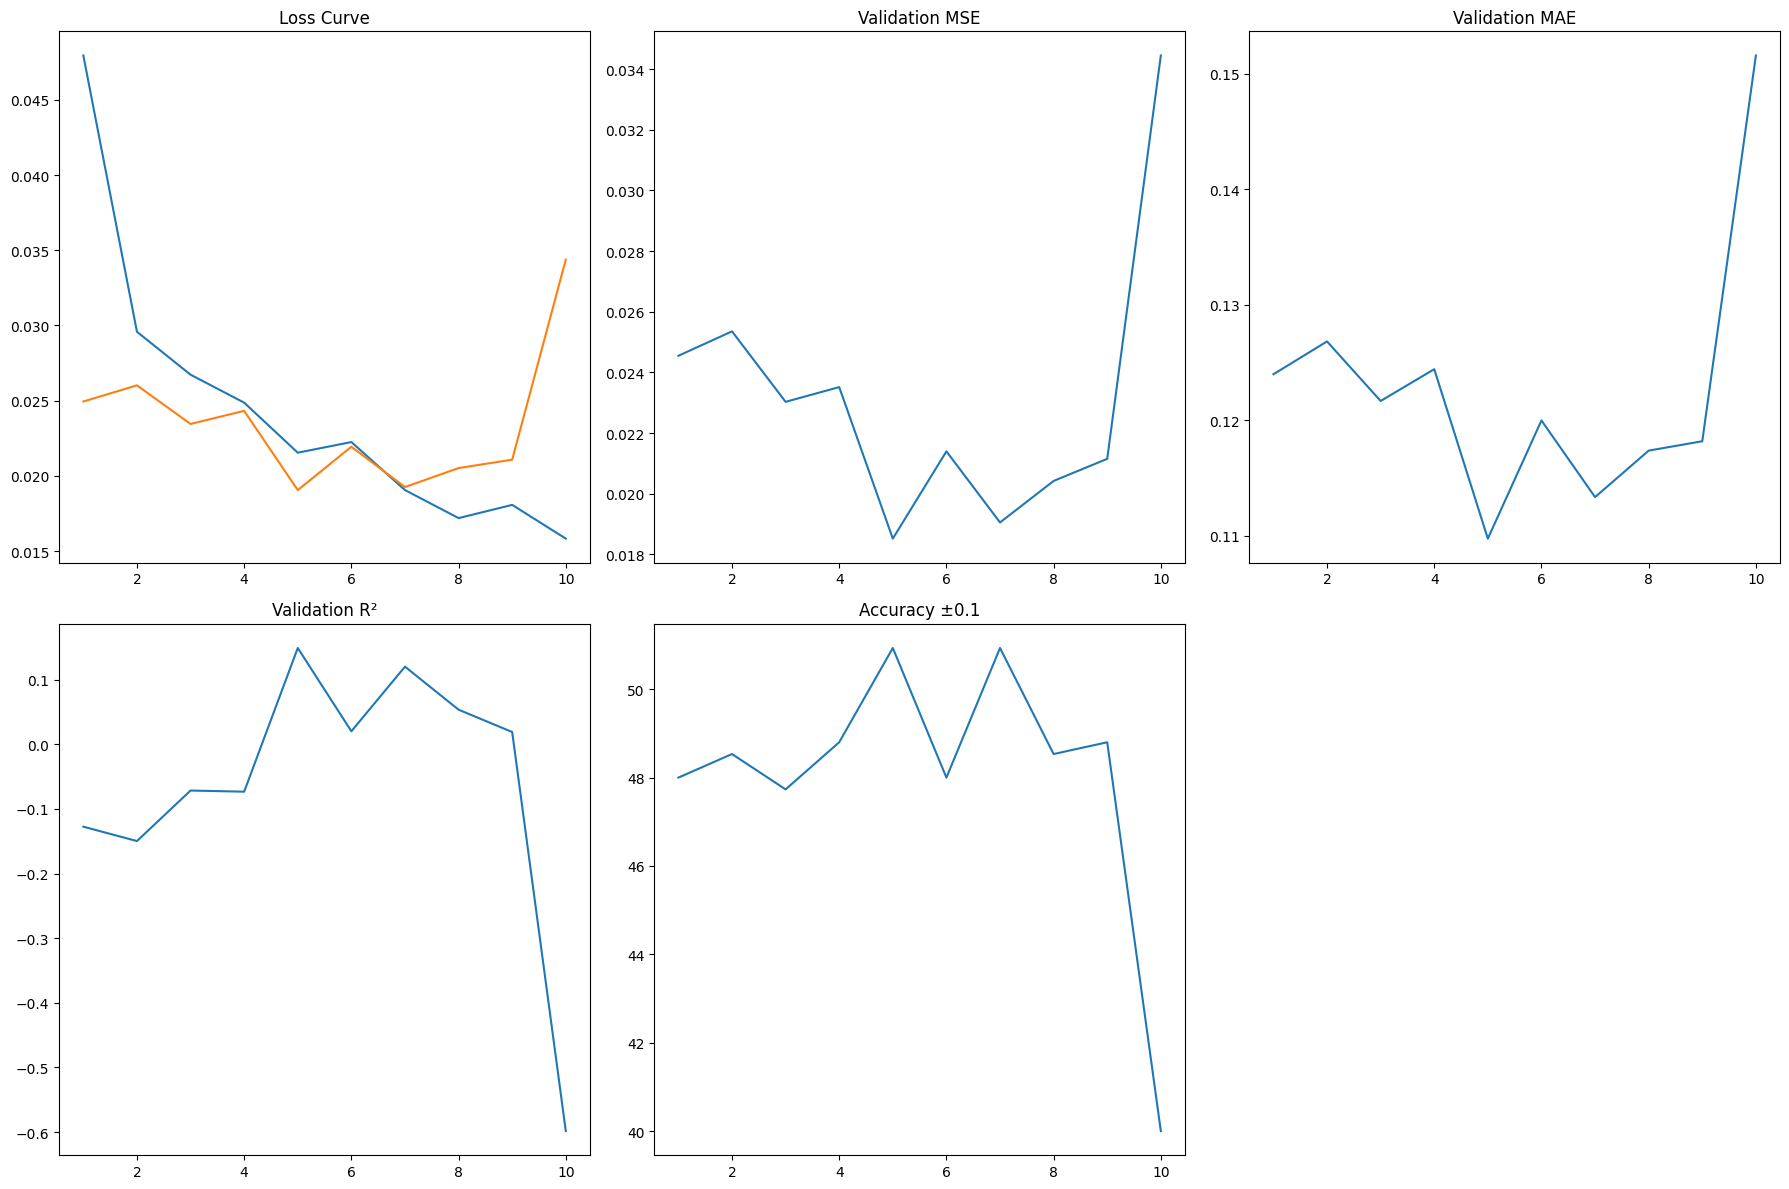


================= FINAL TEST RESULTS =================
MSE: 0.0191
MAE: 0.1102
R²:  -0.2141
Accuracy ±0.1: 54.13%


In [ ]:
# ============================================================
# 📦 Install & Imports   (gru + encoder + transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Features_Project/features_500/"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial.pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial.pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial.pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Encoders + BiGRU + Transformer Model
# ============================================================
class OceanEncBiGRUTransformer(nn.Module):
    def __init__(
        self,
        input_dim=1291,
        clip_dim=512,
        fer_dim=7,
        wav_dim=768,
        prosody_dim=4,
        clip_enc_dim=128,
        fer_enc_dim=32,
        wav_enc_dim=128,
        prosody_enc_dim=16,
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # -------------------------
        # 🔹 Modality Encoders
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(fer_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(prosody_enc_dim),
        )

        fused_dim = clip_enc_dim + fer_enc_dim + wav_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
        )

        # -------------------------
        # 🔹 BiGRU
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        # -------------------------
        # 🔹 Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, 0:self.clip_dim]
        x_fer  = x[:, :, self.clip_dim:self.clip_dim+self.fer_dim]
        x_wav  = x[:, :, self.clip_dim+self.fer_dim:self.clip_dim+self.fer_dim+self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # Encode modalities
        e_clip = self.clip_encoder(x_clip)
        e_fer  = self.fer_encoder(x_fer)
        e_wav  = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        fused = torch.cat([e_clip, e_fer, e_wav, e_pros], dim=-1)
        fused = self.fuse_proj(fused)

        # BiGRU
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # CLS + Transformer
        cls_tok = self.cls_token.expand(B, 1, -1)
        seq = torch.cat([cls_tok, gru_out], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        cls_out = enc[:, 0]

        # Predict OCEAN
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanEncBiGRUTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history)
plt.plot(epochs, val_loss_history)
plt.title("Loss Curve")

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (46, 1292)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Epoch 1 | Train 0.0658 | Val 0.0238 | MSE 0.0242 | MAE 0.1228 | R² -0.0963 | Acc±0.1 49.87%
Epoch 2 | Train 0.0316 | Val 0.0235 | MSE 0.0237 | MAE 0.1205 | R² -0.0805 | Acc±0.1 50.40%
Epoch 3 | Train 0.0260 | Val 0.0243 | MSE 0.0246 | MAE 0.1216 | R² -0.1196 | Acc±0.1 51.73%
Epoch 4 | Train 0.0230 | Val 0.0228 | MSE 0.0232 | MAE 0.1192 | R² -0.0568 | Acc±0.1 49.60%
Epoch 5 | Train 0.0220 | Val 0.0219 | MSE 0.0221 | MAE 0.1151 | R² -0.0045 | Acc±0.1 53.33%
Epoch 6 | Train 0.0186 | Val 0.0219 | MSE 0.0218 | MAE 0.1175 | R² 0.0085 | Acc±0.1 51.73%
Epoch 7 | Train 0.0206 | Val 0.0228 | MSE 0.0229 | MAE 0.1166 | R² -0.0399 | Acc±0.1 53.60%
Epoch 8 | Train 0.0

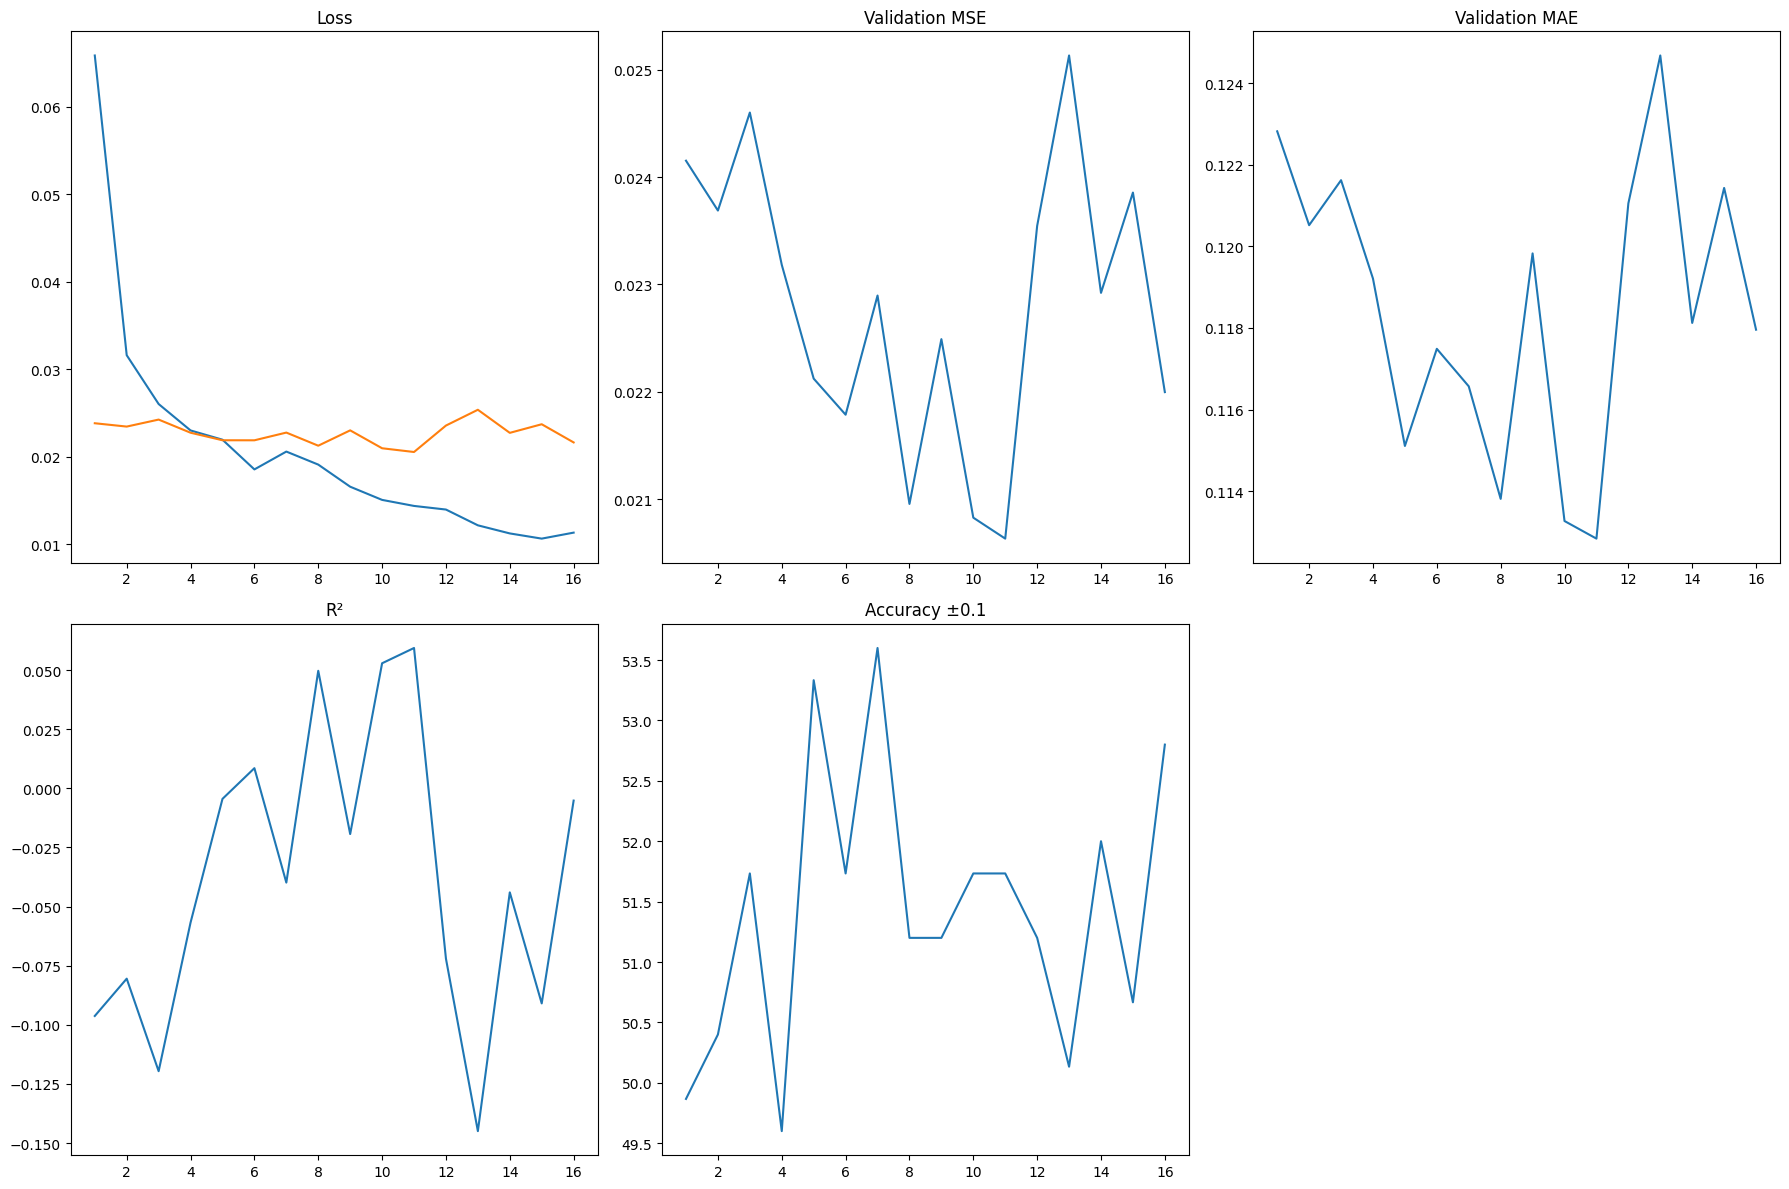


================= FINAL TEST RESULTS =================
MSE: 0.0177
MAE: 0.1042
R²:  0.0493
Accuracy ±0.1: 58.40%


In [ ]:
# ============================================================
# 📦 Install & Imports (BiLSTM + Transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Load Feature Files
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Features_Project/features_500/"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial.pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial.pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial.pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 📦 Dataset + Collate fn
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train/Val/Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Cross-Attention Block
# ============================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, dim)
        )
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        attn, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln1(q + self.dropout(attn))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x


# ============================================================
# 🧠 BiLSTM + Transformer Multimodal Model
# ============================================================
class OceanBiLSTMTransformer(nn.Module):
    def __init__(self,
                 input_dim=1291,
                 clip_dim=512,
                 fer_dim=7,
                 wav_dim=768,
                 prosody_dim=4,
                 clip_enc_dim=128,
                 fer_enc_dim=32,
                 wav_enc_dim=128,
                 prosody_enc_dim=16,
                 d_model=256,
                 dropout=0.2,
                 nhead_xattn=4,
                 nhead_transformer=8,
                 num_layers_transformer=2):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # ------------ Encoders -------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim), nn.ReLU(), nn.LayerNorm(clip_enc_dim)
        )
        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim), nn.ReLU(), nn.LayerNorm(fer_enc_dim)
        )
        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim), nn.ReLU(), nn.LayerNorm(wav_enc_dim)
        )
        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim), nn.ReLU(), nn.LayerNorm(prosody_enc_dim)
        )

        # ------------ Cross Attention -------------
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead_xattn, dropout)
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead_xattn, dropout)

        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # ------------ BiLSTM -------------
        self.bilstm = nn.LSTM(
            d_model, d_model//2,
            batch_first=True,
            bidirectional=True
        )
        self.lstm_ln = nn.LayerNorm(d_model)

        # ------------ Transformer -------------
        self.cls_token = nn.Parameter(torch.randn(1,1,d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead_transformer,
            dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers_transformer)

        # ------------ Regression Head -------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5)
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, :self.clip_dim]
        x_fer  = x[:, :, self.clip_dim:self.clip_dim+self.fer_dim]
        x_wav  = x[:, :, self.clip_dim+self.fer_dim:self.clip_dim+self.fer_dim+self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # Encode
        e_clip = self.clip_encoder(x_clip)
        e_fer  = self.fer_encoder(x_fer)
        e_wav  = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        padding_mask = (mask==0)

        # Cross attention
        clip_ca = self.cross_clip_from_audio(e_clip, e_wav, e_wav, key_padding_mask=padding_mask)
        wav_ca  = self.cross_audio_from_clip(e_wav, e_clip, e_clip, key_padding_mask=padding_mask)

        fused = torch.cat([clip_ca, wav_ca, e_fer, e_pros], dim=-1)
        fused = self.fuse_proj(fused)

        # BiLSTM
        lstm_out, _ = self.bilstm(fused)
        lstm_out = self.lstm_ln(lstm_out)

        # Transformer w/ CLS
        cls = self.cls_token.expand(B,1,-1)
        seq = torch.cat([cls, lstm_out], dim=1)

        full_mask = torch.cat([torch.ones(B,1,device=mask.device), mask], dim=1)
        key_mask = (full_mask==0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        out = enc[:,0]

        return self.head(out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 🏋️ Training
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = OceanBiLSTMTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []
val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS+1):

    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- Validation --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)

            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2,3,1); plt.plot(epochs, train_loss_history); plt.plot(epochs, val_loss_history); plt.title("Loss")
plt.subplot(2,3,2); plt.plot(epochs, val_mse_history); plt.title("Validation MSE")
plt.subplot(2,3,3); plt.plot(epochs, val_mae_history); plt.title("Validation MAE")
plt.subplot(2,3,4); plt.plot(epochs, val_r2_history); plt.title("R²")
plt.subplot(2,3,5); plt.plot(epochs, val_acc_history); plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)

        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")
